### This notebook generates structural connectivity matrices from DWI data.  

Note: Different versions of this NB (eg: v2, v3, etc) play around with the seed density values, or looks at alternate subjects.  

In [1]:
# importage

import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
from matplotlib import cm

import os,sys,glob,numpy as np, pandas as pd

from skimage import measure

import nibabel as nib
from nilearn.plotting import plot_surf, plot_surf_stat_map, plot_roi, plot_anat, plot_surf_roi

%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from nilearn.image import index_img

from dipy.core.gradients import gradient_table
from dipy.reconst import shm
from dipy.direction import peaks

from dipy.tracking import utils
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines
from dipy.tracking.stopping_criterion import BinaryStoppingCriterion
from dipy.io.dpy import Dpy


import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap

from dipy.tracking.distances import approx_polygon_track

In [2]:
import nilearn

In [3]:
# Load the DWI data

bvecs_file = '/external/rprshnas01/public_datasets/HCP/HCP_S900/151526/T1w/Diffusion/bvecs'
bvecs_dat = np.loadtxt(bvecs_file)

bvals_file = '/external/rprshnas01/public_datasets/HCP/HCP_S900/151526/T1w/Diffusion/bvals'
bvals_dat = np.loadtxt(bvals_file)


# laoding a dwi file is similar to loading in a dconn file ...

dwi_file = '/external/rprshnas01/public_datasets/HCP/HCP_S900/151526/T1w/Diffusion/data.nii.gz'
dwi_img = nib.load(dwi_file)
dwi_dat = dwi_img.get_data()

b0_img = index_img(dwi_img,0)

# load brain mask file ...

nbm_file = '/external/rprshnas01/public_datasets/HCP/HCP_S900/151526/T1w/Diffusion/nodif_brain_mask.nii.gz'
nbm_img = nib.load(nbm_file)
nbm_dat = nbm_img.get_data()

In [4]:
gtab = gradient_table(bvals_dat, bvecs_dat)

affine = dwi_img.affine

In [8]:
%%time

# This cell takes between 6 to 8 mins to run (approx).

csamodel = shm.CsaOdfModel(gtab, 6)
csapeaks = peaks.peaks_from_model(model=csamodel,
                                  data=dwi_dat,
                                  sphere=peaks.default_sphere,
                                  relative_peak_threshold=.8,
                                  min_separation_angle=45,
                                  mask=nbm_dat.astype(bool))

CPU times: user 7min 40s, sys: 31.3 s, total: 8min 11s
Wall time: 8min 12s


In [9]:
aff = b0_img.affine

##### Set the seed density value to 1 (default)

In [10]:
seeds = utils.seeds_from_mask(nbm_dat,aff,density=[1,1,1])

In [11]:
from dipy.tracking.stopping_criterion import BinaryStoppingCriterion

In [12]:
stopping_criterion = BinaryStoppingCriterion(nbm_dat)

In [13]:
%%time
streamline_generator = LocalTracking(csapeaks, stopping_criterion, seeds, affine=aff, step_size=0.5)

CPU times: user 51 µs, sys: 996 µs, total: 1.05 ms
Wall time: 760 µs


In [14]:
%%time
# This step takes a long time to run!
# It takes a minimum of ~45 minutes to run, with higher seed density values having a significantly longer runtime ...

streamlines = Streamlines(streamline_generator)

CPU times: user 23min 20s, sys: 30min 21s, total: 53min 41s
Wall time: 53min 53s


In [15]:
len(streamlines)

1894941

In [16]:
%%time
# This step take 3 minutes to run. 
streamlines_ds = np.array([approx_polygon_track(s) for s in streamlines])

CPU times: user 3min 12s, sys: 7.85 s, total: 3min 20s
Wall time: 3min 20s


#### Put the streamlines in a structural connectivity matrix

In [64]:
# Load the label file and brain mask file

label_file_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/PyTepFit/Data/fs_directory/151526/mri/151526_Schaefer2018_400Parcels_7Networks_rewritten.nii.gz'
mask_file_path = '/external/rprshnas01/public_datasets/HCP/HCP_S900/151526/T1w/Diffusion/nodif_brain_mask.nii.gz'

label_img = nib.load(label_file_path)
label_data = label_img.get_data()
mask_img = nib.load(mask_file_path)

In [69]:
label_data.shape

(256, 256, 256)

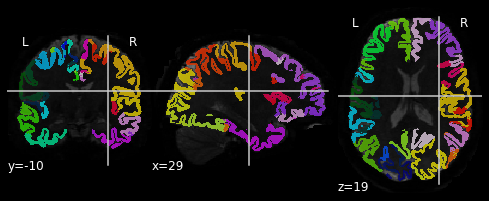

In [65]:
from nilearn import plotting as nplot


nplot.plot_roi(label_img, dwi_img.slicer[:, :, :, 0])


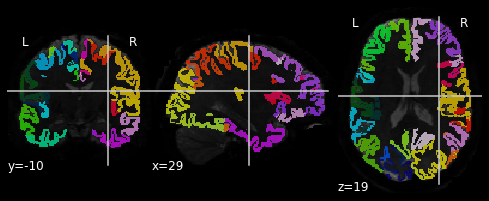

In [61]:
from nilearn import plotting as nplot


nplot.plot_roi(resampled_label_dat, dwi_img.slicer[:, :, :, 0])


In [17]:
# Load the label file and brain mask file

label_file_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/PyTepFit/Data/fs_directory/151526/mri/151526_Schaefer2018_400Parcels_7Networks_rewritten.nii.gz'
mask_file_path = '/external/rprshnas01/public_datasets/HCP/HCP_S900/151526/T1w/Diffusion/nodif_brain_mask.nii.gz'

label_img = nib.load(label_file_path)
mask_img = nib.load(mask_file_path)

Note:  
```
label_img.shape = (256, 256, 256)
mask_img.shape = (145, 174, 145)
```  
   
There is a difference in the shape of the label file and the brain mask file.    
In order to match the shape of the label file to the brain mask file, use ...  
```nilearn.image.resample_img()```, with the value of ```interpolation``` set to ```'nearest'```  


In [18]:
# label_img.shape

(256, 256, 256)

In [19]:
mask_img.shape

(145, 174, 145)

In [21]:
%%time
resampled_label_dat = nilearn.image.resample_img(label_file_path, target_affine=nbm_img.affine, target_shape=mask_img.shape,interpolation='nearest')

CPU times: user 1.7 s, sys: 204 ms, total: 1.91 s
Wall time: 2.09 s


In [22]:
resampled_label_dat.shape

(145, 174, 145)

In [23]:
resampled_label_data = resampled_label_dat.get_data()

In [25]:
# np.unique(resampled_label_data)

In [71]:
%%time
conn_mat, grouping = utils.connectivity_matrix(streamlines_ds,
                                               b0_img.affine,
                                               resampled_label_data,
                                               return_mapping=True,
                                               mapping_as_streamlines=True)

CPU times: user 8.42 s, sys: 518 ms, total: 8.94 s
Wall time: 8.94 s


In [72]:
conn_mat = conn_mat[1:, 1:]

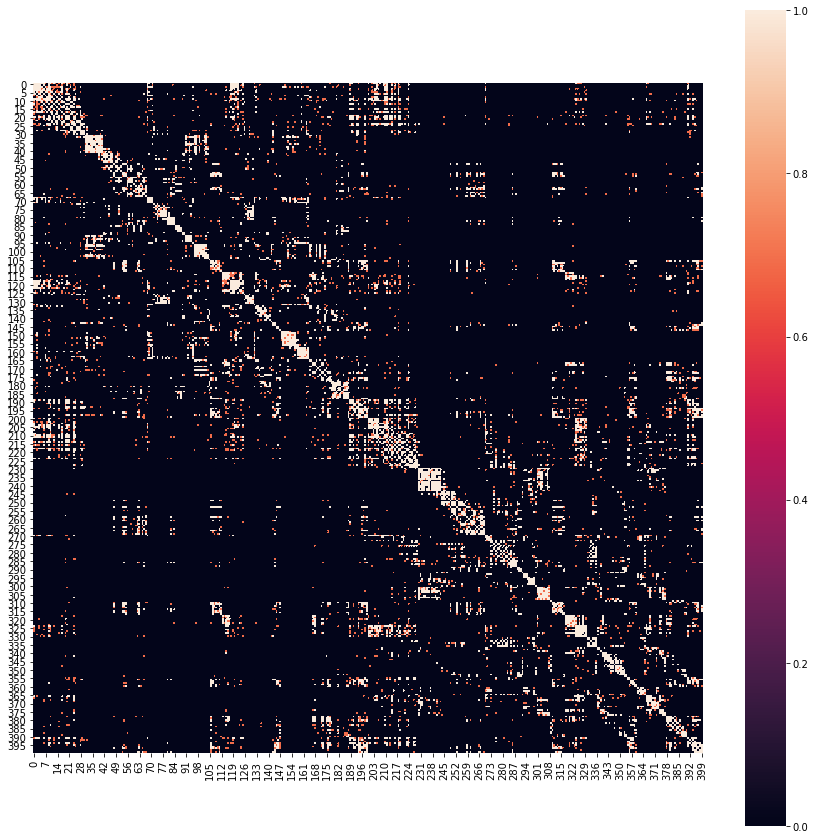

In [74]:
fig, ax = plt.subplots(figsize=(15,15))

sns.heatmap(np.log1p(conn_mat), ax=ax, vmax=1)
ax.set_aspect('equal')

In [53]:
# Load the label file and brain mask file

label_file_path2 = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/PyTepFit/Data/fs_directory/151526/mri/151526_Schaefer2018_400Parcels_7Networks_rewritten.nii.gz'
mask_file_path2 = '/external/rprshnas01/public_datasets/HCP/HCP_S900/151526/T1w/Diffusion/nodif_brain_mask.nii.gz'

label_img2 = nib.load(label_file_path2)
mask_img2 = nib.load(mask_file_path2)

In [63]:

nbm_file = '/external/rprshnas01/public_datasets/HCP/HCP_S900/151526/T1w/Diffusion/nodif_brain_mask.nii.gz'
nbm_img = nib.load(nbm_file)
nbm_dat = nbm_img.get_data()

In [62]:
nbm_img.affine

array([[  -1.25,    0.  ,    0.  ,   90.  ],
       [   0.  ,    1.25,    0.  , -126.  ],
       [   0.  ,    0.  ,    1.25,  -72.  ],
       [   0.  ,    0.  ,    0.  ,    1.  ]])

In [54]:
%%time
resampled_label_dat2 = nilearn.image.resample_img(label_file_path2, target_affine=nbm_img.affine, target_shape=mask_img.shape,interpolation='nearest')

CPU times: user 1.66 s, sys: 184 ms, total: 1.84 s
Wall time: 1.98 s


In [55]:
resampled_label_data2 = resampled_label_dat2.get_data()

In [56]:
%%time
conn_mat2, grouping2 = utils.connectivity_matrix(streamlines_ds,
                                               b0_img.affine,
                                               resampled_label_data2,
                                               return_mapping=True,
                                               mapping_as_streamlines=True)

CPU times: user 8.64 s, sys: 736 ms, total: 9.38 s
Wall time: 9.37 s


In [57]:
conn_mat2 = conn_mat2[1:, 1:]

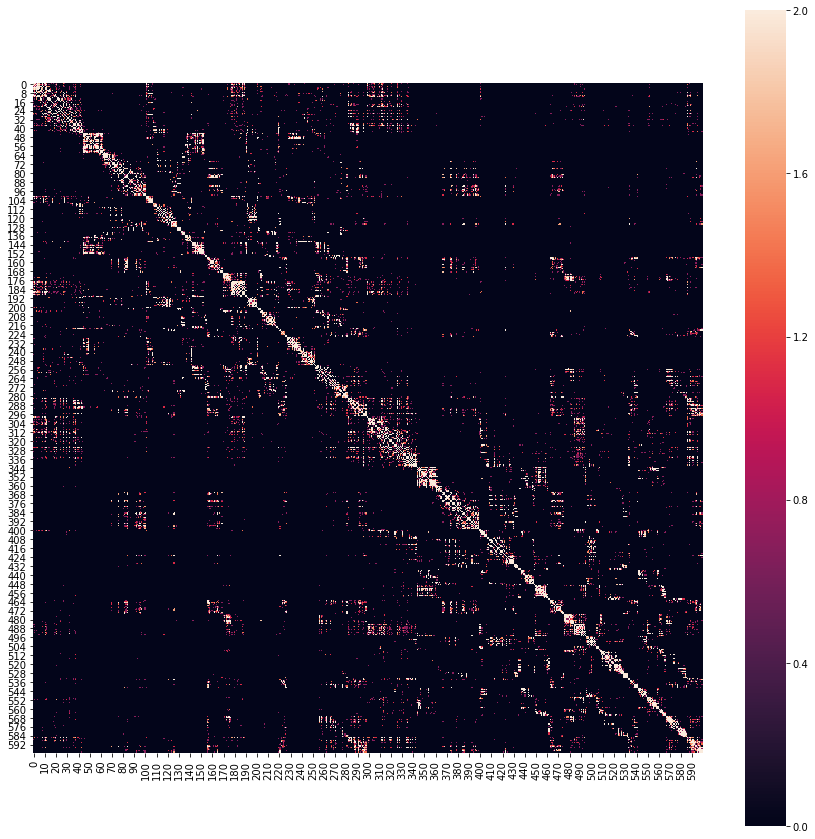

In [58]:
fig, ax = plt.subplots(figsize=(15,15))

sns.heatmap(np.log1p(conn_mat2),ax=ax,vmax=2)
ax.set_aspect('equal')

From the above heatmap, it is evident that the density maybe a bit low.  
Subsequent notebooks focus on playing around with the ```density``` value in the ```utils.seeds_from_mask()``` function.

In [29]:
conn_mat.shape

(400, 400)

In [30]:
type(conn_mat)

numpy.ndarray

In [33]:
conn_mat.dtype

dtype('int64')

In [35]:
# Save the array as a .txt file
np.savetxt('sub_151526_dwi_str_conn_ntx_density_1.txt', conn_mat, fmt='%d')

In [36]:
seeds

array([[ 67.5 , -43.5 ,   1.75],
       [ 67.5 , -43.5 ,   3.  ],
       [ 67.5 , -43.5 ,   4.25],
       ...,
       [-67.5 , -18.5 ,  -9.5 ],
       [-67.5 , -18.5 ,  -8.25],
       [-67.5 , -18.5 ,  -7.  ]])

In [59]:
pwd

'/external/rprshnas01/kcni/hharita/Code/whobpyt/Intro_to_dMRI_workshop'